# Model Training
This notebook will cover:
- How we create the model by applying transfer learning from several pretrained models on `ImageNet` dataset
- How we perfrom data augmentation that can avoid overfitting on training dataset
- How we find the best tunning for each model
- How we track the experiments using MLFlow so we can evaluate it

After we try a lot of different hyper-parameters tunning, we will select the best model to be fine-tunned on the other notebook.

## Import Libraries

In [1]:
# Suppress other warngins
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR

# Import main libraries
import mlflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2025-04-24 05:48:48.113684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745473728.135317   84741 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745473728.141848   84741 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745473728.158677   84741 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745473728.158699   84741 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745473728.158701   84741 computation_placer.cc:177] computation placer alr

## Check GPU Availability
Check whether we have a GPU instance.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(f'{gpu.name}')
            print(f'Physical GPUs: {len(gpus)}')
            print(f'Logical GPUs: {len(logical_gpus)}')

        except RuntimeError as e:
            print(e)

/physical_device:GPU:0
Physical GPUs: 1
Logical GPUs: 1


I0000 00:00:1745473731.044285   84741 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14485 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


## Setup Experiment Tracking
We will try to find the best hyper-parameters for this model. So, we need an `MLFlow` or similar tools like `Weight and Biases` to track all our experiments and log the models.

Assume the MLFlow is already running by executing this command: `mlflow server --host 127.0.0.1 --port 5000`

In [3]:
EXPERIMENT_NAME = 'mobilenet-augmentation'
# EXPERIMENT_NAME = 'transfer-learning'
# EXPERIMENT_NAME = 'efficientnet'
EXPERIMENT_BASE = 'http://127.0.0.1:5001'

# Setup tracking
mlflow.set_tracking_uri(uri=EXPERIMENT_BASE)
mlflow.enable_system_metrics_logging()

# Enable autologging for TensorFlow
mlflow.tensorflow.autolog()

# Set experiment name
mlflow.set_experiment(EXPERIMENT_NAME)

2025/04/24 05:48:51 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.18.0, but the installed version is 2.19.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.


<Experiment: artifact_location='mlflow-artifacts:/469041474712159970', creation_time=1745247156495, experiment_id='469041474712159970', last_update_time=1745297524346, lifecycle_stage='active', name='mobilenet-augmentation', tags={}>

# Hyper Parameters
Define hyper-parameters we will use. We can try different hyper-parameters we need.

In [4]:
CLASS_NAMES = ['architecture', 'art and culture', 'food and drinks', 'travel and adventure']
CLASS_TO_INDEX = {name: idx for idx, name in enumerate(CLASS_NAMES)}

IMAGE_SIZE = IMAGE_HEIGHT, IMAGE_WIDTH = 320, 380
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BASE_MODEL_NAMES = ['resnet_50', 'efficientnet', 'efficientnet_v2', 'convnext', 'nasnet', 'mobilenet']

parameters = {
    'model': BASE_MODEL_NAMES[5],
    'width': IMAGE_WIDTH,
    'height': IMAGE_HEIGHT,
    'image_size': IMAGE_SIZE,
    'class_names': CLASS_NAMES,
    'learning_rate': 1e-04,
    'batch_size': 124,
    'dropout': 0.20,
    'dense': 1024,
    'epochs': 24,
    'aug': 0.5,
}

# Load Datasets
Because the dataset is already clean, we can load it directly using `image_dataset_from_directory()` from TensorFlow.

In [5]:
TRAIN_DIR = '../datasets/train'
VAL_DIR = '../datasets/validation'

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    class_names=parameters['class_names'],
    batch_size=parameters['batch_size'],
    image_size=parameters['image_size'],
    shuffle=True,
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    label_mode='categorical',
    class_names=parameters['class_names'],
    batch_size=parameters['batch_size'],
    image_size=parameters['image_size'],
    shuffle=True,
)

Found 34991 files belonging to 4 classes.
Found 115 files belonging to 4 classes.


## Preview Dataset
Let's see current original dataset

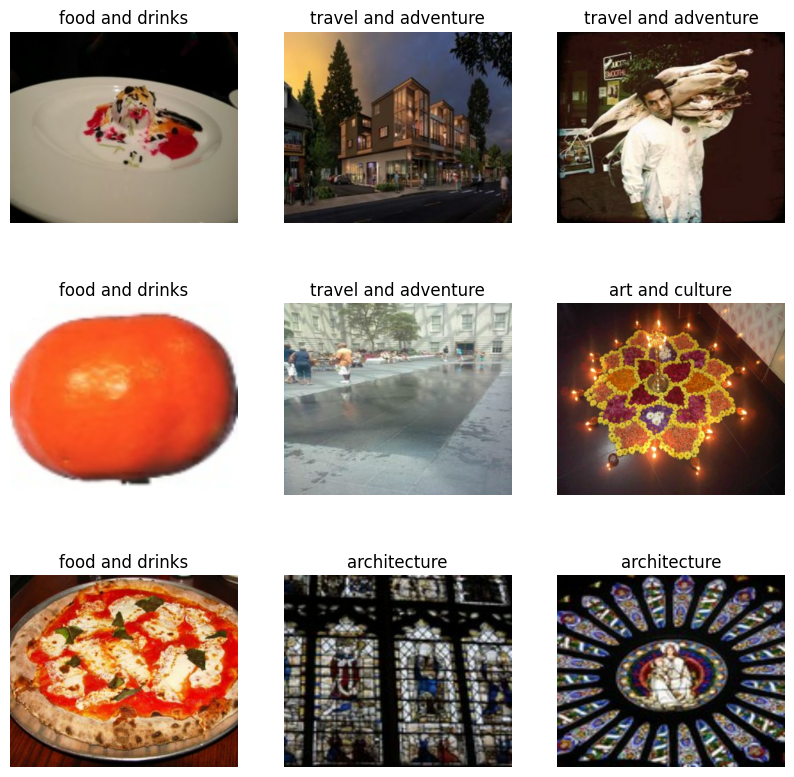

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(min(9, parameters['batch_size'])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[np.argmax(labels[i].numpy())])
    plt.axis("off")

# Agumentation
Augmentation is a good technique to avoid overfitting on training dataset that can result hight accuracy on training data but lower on validation data.

Data augmentation is one of regularization but we applied to data. We will also apply regularization inside the model with `DropOut` layers.

In [8]:
data_augmentation = tf.keras.Sequential([
    # Geometric Transformations
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(2 * parameters['aug']),
    tf.keras.layers.RandomZoom(height_factor=2 * parameters['aug'], width_factor=2 * parameters['aug']),
    tf.keras.layers.RandomTranslation(2 * parameters['aug'], 2 * parameters['aug']),

    # Color augmentations
    tf.keras.layers.RandomBrightness(factor=parameters['aug']),
    tf.keras.layers.RandomContrast(factor=parameters['aug']),
    tf.keras.layers.RandomHue(factor=parameters['aug']),
])

## Preview Augmentation
Let's see how augmentation change the data

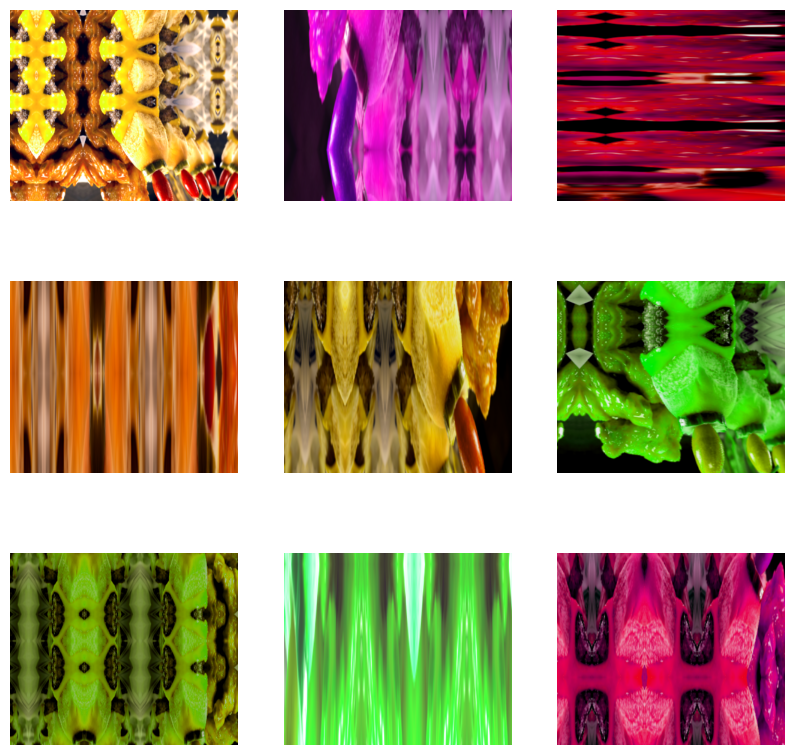

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Prefect Dataset
To speed up the process of preprocessing the data and training the model, we can prefect the dataset so while the GPU is performing forward or backward pass, CPU will prepare the data for next dataset batch.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Model

## Base Model

In [11]:
def get_preprocessing_and_base_model(model_name, input_shape):
    model_name = model_name.lower()

    if model_name == 'mobilenet':
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
        base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    
    elif model_name == 'resnet_50':
        preprocess_input = tf.keras.applications.resnet50.preprocess_input
        base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    
    elif model_name == 'efficientnet':
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
        base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    
    elif model_name == 'efficientnet_v2':
        preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
        base_model = tf.keras.applications.EfficientNetV2B0(input_shape=input_shape, include_top=False, weights='imagenet')
    
    elif model_name == 'convnext':
        preprocess_input = tf.keras.applications.convnext.preprocess_input
        base_model = tf.keras.applications.ConvNeXtTiny(input_shape=input_shape, include_top=False, weights='imagenet')

    elif model_name == 'nasnet':
        preprocess_input = tf.keras.applications.nasnet.preprocess_input
        base_model = tf.keras.applications.NASNetMobile(input_shape=input_shape, include_top=False, weights='imagenet')

    else:
        raise ValueError(f"Unsupported model: {model_name}")

    base_model.trainable = False
    return preprocess_input, base_model

# Get preprocessing function and base model
preprocess_input, base_model = get_preprocessing_and_base_model(parameters['model'], IMAGE_SHAPE)
base_model.trainable = False

/tmp/ipykernel_84741/304504768.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


## Build Model
This model will use pre-processing and feature extractor layer form `MobileNet`.
On top of it, we will add our own classifier using several dense layers.

In [12]:
# Input layer
inputs = tf.keras.Input(shape=IMAGE_SHAPE)

# Pre-process + Augmentation layer (optional)
if parameters['aug'] > 0:
    x = data_augmentation(inputs)
    x = preprocess_input(x)
else:
    x = preprocess_input(inputs)

# Feature extractor
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Classifier
x = tf.keras.layers.Dense(
    parameters['dense'],
    kernel_initializer=tf.keras.initializers.GlorotUniform()
)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(parameters['dropout'])(x)

x = tf.keras.layers.Dense(
    parameters['dense'] // 2,
    kernel_initializer=tf.keras.initializers.HeNormal()
)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(parameters['dropout'])(x)

outputs = tf.keras.layers.Dense(len(parameters['class_names']), activation='sigmoid')(x)

# Build model
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 320, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 320, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 320, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 320, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 10, 12, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 1,838,596 (7.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Compile
Compile the model with learning rate, loss and metrics we want to track.

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=parameters['learning_rate']),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

## Callbacks
Several useful call back used in this code are:
- Early Stopping: avoid waiting until end of epoch if there is no improvement
- Model Checkpoint: save whenever the model has any improvement
- Tensor Board: log any necessary informations about the model and metrics

In [14]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, min_epochs=4, patience=4):
        super().__init__()
        self.min_epochs = min_epochs
        self.patience = patience
        self.wait = 0
        self.best = float('inf')
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if current is None:
            return

        if current < self.best - 0.001:
            self.best = current
            self.wait = 0
        else:
            if epoch + 1 >= self.min_epochs:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Stopped training at epoch {self.stopped_epoch + 1}")

In [15]:
# Callbacks
checkpoint_path = "checkpoints/efficientnetb0.keras"
callbacks = [
    # TensorBoard
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),

    # Checkpoint
    tf.keras.callbacks.ModelCheckpoint(
        monitor='val_loss', 
        filepath=checkpoint_path, 
        save_best_only=True, 
        mode='min',
    ),

    # Early stopping
    CustomEarlyStopping(
        min_epochs=8, 
        patience=4,
    ),

    # Reducer
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',     # Metric to monitor
        factor=0.5,             # Factor to reduce LR (new_lr = old_lr * factor)
        patience=3,             # Wait X epochs before reducing LR
        min_lr=1e-9,            # Do not go below this LR
        verbose=1,
    )
]

# Training

In [16]:
with mlflow.start_run(log_system_metrics=True) as run:
    # Log params
    mlflow.log_params(parameters)

    # Train
    history = model.fit(
        train_dataset,
        epochs=parameters['epochs'],
        validation_data=validation_dataset,
        batch_size=parameters['batch_size'],
        callbacks=callbacks,
    )
    
    # Load the best model
    best_model = tf.keras.models.load_model(checkpoint_path)
    val_loss, val_acc = best_model.evaluate(validation_dataset)

    # Log models
    mlflow.tensorflow.log_model(best_model, "best")
    mlflow.tensorflow.log_model(model, "last")

    # Log metrics
    mlflow.log_metric("best_loss", val_loss)
    mlflow.log_metric("best_accuracy", val_acc)

2025/04/24 05:49:01 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/04/24 05:49:01 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch 1/24


I0000 00:00:1745473795.009175   84906 cuda_dnn.cc:529] Loaded cuDNN version 90300


283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5312 - loss: 1.0926

2025/04/24 05:50:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot pickle 'module' object


283/283 ━━━━━━━━━━━━━━━━━━━━ 55s 165ms/step - accuracy: 0.5314 - loss: 1.0921 - val_accuracy: 0.7826 - val_loss: 0.5042 - learning_rate: 1.0000e-04
Epoch 2/24
282/283 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6471 - loss: 0.8495

2025/04/24 05:51:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot pickle 'module' object


283/283 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.6471 - loss: 0.8494 - val_accuracy: 0.7826 - val_loss: 0.4833 - learning_rate: 1.0000e-04
Epoch 3/24
282/283 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6671 - loss: 0.8138

2025/04/24 05:52:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot pickle 'module' object


283/283 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.6671 - loss: 0.8138 - val_accuracy: 0.8435 - val_loss: 0.4612 - learning_rate: 1.0000e-04
Epoch 4/24
283/283 ━━━━━━━━━━━━━━━━━━━━ 44s 154ms/step - accuracy: 0.6743 - loss: 0.7961 - val_accuracy: 0.8174 - val_loss: 0.5053 - learning_rate: 1.0000e-04
Epoch 5/24
282/283 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6809 - loss: 0.7879

2025/04/24 05:53:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot pickle 'module' object


283/283 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.6810 - loss: 0.7878 - val_accuracy: 0.8348 - val_loss: 0.4402 - learning_rate: 1.0000e-04
Epoch 6/24
283/283 ━━━━━━━━━━━━━━━━━━━━ 44s 154ms/step - accuracy: 0.6893 - loss: 0.7640 - val_accuracy: 0.7913 - val_loss: 0.4994 - learning_rate: 1.0000e-04
Epoch 7/24
282/283 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6903 - loss: 0.7640

2025/04/24 05:55:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot pickle 'module' object


283/283 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.6903 - loss: 0.7640 - val_accuracy: 0.8435 - val_loss: 0.4152 - learning_rate: 1.0000e-04
Epoch 8/24
282/283 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6915 - loss: 0.7572

2025/04/24 05:55:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot pickle 'module' object


283/283 ━━━━━━━━━━━━━━━━━━━━ 45s 157ms/step - accuracy: 0.6915 - loss: 0.7571 - val_accuracy: 0.8783 - val_loss: 0.3562 - learning_rate: 1.0000e-04
Epoch 9/24
283/283 ━━━━━━━━━━━━━━━━━━━━ 44s 154ms/step - accuracy: 0.6920 - loss: 0.7572 - val_accuracy: 0.8348 - val_loss: 0.4435 - learning_rate: 1.0000e-04
Epoch 10/24
283/283 ━━━━━━━━━━━━━━━━━━━━ 44s 154ms/step - accuracy: 0.6949 - loss: 0.7470 - val_accuracy: 0.8261 - val_loss: 0.4232 - learning_rate: 1.0000e-04
Epoch 11/24
282/283 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6979 - loss: 0.7405
Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
283/283 ━━━━━━━━━━━━━━━━━━━━ 44s 154ms/step - accuracy: 0.6980 - loss: 0.7405 - val_accuracy: 0.8348 - val_loss: 0.4125 - learning_rate: 1.0000e-04
Epoch 12/24
283/283 ━━━━━━━━━━━━━━━━━━━━ 44s 154ms/step - accuracy: 0.7038 - loss: 0.7312 - val_accuracy: 0.8348 - val_loss: 0.3981 - learning_rate: 5.0000e-05
Stopped training at epoch 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s

2025/04/24 05:59:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/24 05:59:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/24 05:59:12 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/24 05:59:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/24 05:59:21 INFO mlflow.system_metrics.system_metrics_monitor: Stoppin

🏃 View run aug-0.5 at: http://127.0.0.1:5001/#/experiments/469041474712159970/runs/c083eea567f14385b93572bc14af3509
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/469041474712159970
